In [16]:
from torch import nn, optim, tensor, max
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
import numpy as np

In [17]:
# def plot_channels(W):
#     n_out = W.shape[0]
#     n_in = W.shape[1]
#     w_min = W.min().item()
#     w_max = W.max().item()
#     fig, axes = plt.subplots(n_out, n_in)
#     fig.subplots_adjust(hspace=0.1)
#     out_index = 0
#     in_index = 0
#
#     #plot outputs as rows inputs as columns
#     for ax in axes.flat:
#         if in_index > n_in - 1:
#             out_index = out_index + 1
#             in_index = 0
#         ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
#         ax.set_yticklabels([])
#         ax.set_xticklabels([])
#         in_index = in_index + 1
#
#     plt.show()

In [18]:
def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows, figsize=(12, 10))
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [19]:
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows, figsize=(12, 10))
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1), rotation=45)

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)
    plt.show()

In [20]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy(), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    plt.show()

In [21]:
reshape_as_tensor_transform = transforms.Compose([transforms.ToTensor()])

In [22]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=reshape_as_tensor_transform)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=reshape_as_tensor_transform)

In [23]:
class CNN(nn.Module):

    # Constructor
    def __init__(self, out_1=64, out_2=32, out_3=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1)

        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=3, stride=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        # use He initialization
        linear = nn.Linear(800, 128)
        nn.init.kaiming_uniform_(linear.weight, nonlinearity='leaky_relu')
        self.fc1 = linear
        self.bn1 = nn.BatchNorm1d(128)

        linear = nn.Linear(128, 64)
        nn.init.kaiming_uniform_(linear.weight, nonlinearity='leaky_relu')
        self.fc2 = linear
        self.bn2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 10)

    # prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = nn.LeakyReLU()(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = nn.LeakyReLU()(x)

        x = self.cnn3(x)
        x = nn.LeakyReLU()(x)
        x = self.maxpool3(x)
        # print(x.size())


        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.SiLU()(x)

        x = self.fc3(x)
        return x

    # outputs of the convolutions
    def activations(self, x):
        z1 = self.cnn1(x)
        a1 = self.maxpool1(nn.LeakyReLU()(z1))


        z2 = self.cnn2(a1)
        a2 = nn.LeakyReLU()(z2)

        return z1, a1, z2, a2

In [24]:
model = CNN()

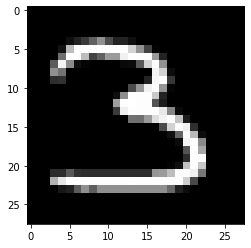

The model sees a 0


In [25]:
# run a prediction before training
r = np.random.randint(0, len(validation_dataset) - 1)

img = validation_dataset[r][0][0]
plt.imshow(img.numpy(), cmap="gray")
plt.show()

model.eval()
pred = model(validation_dataset[r][0].unsqueeze(0))
_, label = max(pred, 1)
print(f"The model sees a {label[0]}")

In [26]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_trainable_parameters(model)

141194

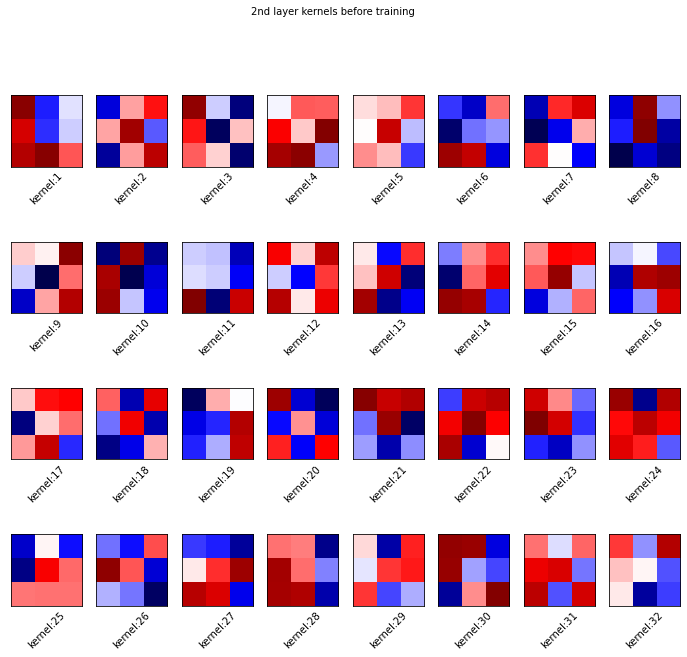

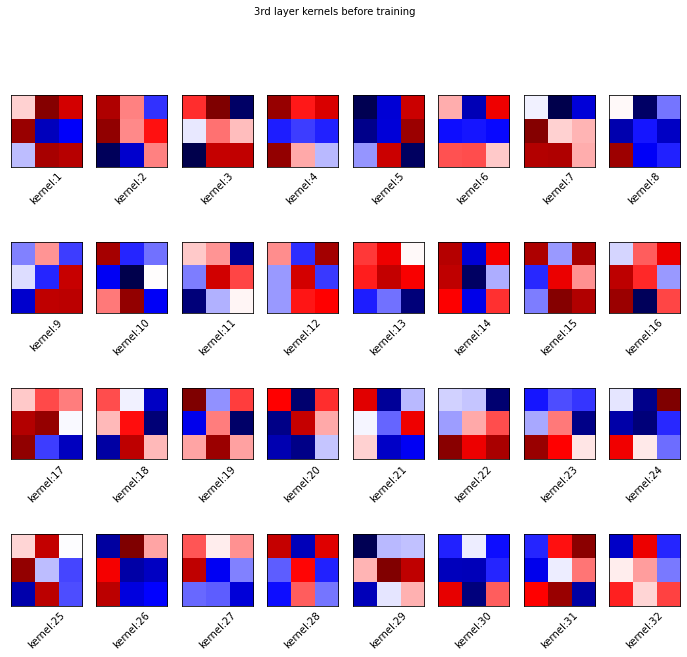

In [27]:
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name="2nd layer kernels before training ")
plot_parameters(model.state_dict()['cnn3.weight'], number_rows=4, name='3rd layer kernels before training')

In [28]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=train_dataset, batch_size=256)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=512)

In [29]:
# set up gpu training
device = None
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda:0")
    model.to(device)

device

device(type='cuda', index=0)

In [30]:
# train the model

n_epochs = 20
cost_list = []
accuracy_list = []
N_test = len(validation_dataset)
COST = 0

# set the model to training mode
model.train()

def train_model(n_epochs):
    for epoch in range(n_epochs):
        print(f"Starting train epoch {epoch + 1}")
        COST = 0
        model.train()
        for x, y in train_loader:
            if device is not None:
                x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            COST += loss.data
        print(f"Done.")
        print(f"\tTraining Cost: {COST}")

        cost_list.append(COST)
        correct = 0
        # measure accuracy on the validation data
        model.eval()
        for x_test, y_test in validation_loader:
            if device is not None:
                x_test, y_test = x_test.to(device), y_test.to(device)
            out = model(x_test)
            _, yhat = max(out.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        print(f"\tValidation Accuracy: {accuracy}")


train_model(n_epochs)

Starting train epoch 1
Done.
	Training Cost: 29.621957778930664
	Validation Accuracy: 0.9717
Starting train epoch 2
Done.
	Training Cost: 9.477383613586426
	Validation Accuracy: 0.9865
Starting train epoch 3
Done.
	Training Cost: 7.007047653198242
	Validation Accuracy: 0.9892
Starting train epoch 4
Done.
	Training Cost: 5.396060466766357
	Validation Accuracy: 0.9856
Starting train epoch 5
Done.
	Training Cost: 4.298807144165039
	Validation Accuracy: 0.9897
Starting train epoch 6
Done.
	Training Cost: 3.5744762420654297
	Validation Accuracy: 0.9877
Starting train epoch 7
Done.
	Training Cost: 2.9234793186187744
	Validation Accuracy: 0.9843
Starting train epoch 8
Done.
	Training Cost: 3.0441207885742188
	Validation Accuracy: 0.986
Starting train epoch 9
Done.
	Training Cost: 2.56152081489563
	Validation Accuracy: 0.9829
Starting train epoch 10
Done.
	Training Cost: 1.945377230644226
	Validation Accuracy: 0.9857
Starting train epoch 11
Done.
	Training Cost: 2.503600597381592
	Validation A

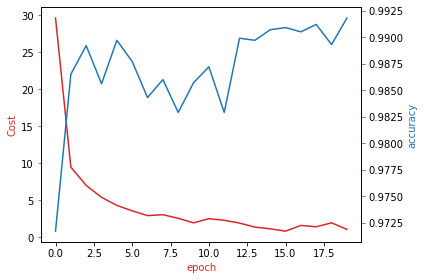

In [31]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [35]:
out = model.activations(train_dataset[1][0].to(device).view(1, 1, 28, 28))
# plot the first layer
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [36]:
# plot the first layer after activation function applied
plot_activations(out[1], number_rows=4, name="Output after the 1st ReLU")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [37]:
# plot the mis-classified samples

count = 0
for x, y in validation_loader:
    z = model(x)
    _, yhat = max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ", yhat)
        count += 1
    if count >= 5:
        break

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor